In [1]:
%autosave 60

Autosaving every 60 seconds


# Импортируем библиотеки

In [2]:
import numpy as np
import pandas as pd

import re
from tqdm import tqdm
from collections import Counter

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from gensim.models import Word2Vec
from nltk.util import ngrams

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification, AdamW

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

plt.style.use('seaborn') 
sns.set_style('whitegrid')

# Выгружаем данные 

In [3]:
train_df = pd.read_excel('/kaggle/input/rostelecom/train.xlsx')
test_df = pd.read_excel('/kaggle/input/rostelecom/test.xlsx')

In [4]:
train_df.head(3)

,text,target
0,"Здравствуйте, как поменять пароль на самом Wi-Fi",2
1,У меня 2 день нет интернета,0
2,Можно узнать почему скачит пинг в игре?,6


In [5]:
test_df.head(3)

,id,text
0,0,Как поставить пароль на вай-фай
1,1,Почему низкая скорость интернета?
2,2,"Здравствуйте. Это просто не выносимо, каждый д..."


# EDA

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2442 entries, 0 to 2441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2442 non-null   object
 1   target  2442 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.3+ KB


In [7]:
train_df.shape

(2442, 2)

In [8]:
test_df.shape

(250, 2)

### Посмотрим примеры обращений клиентов

In [9]:
pd.set_option('display.max_colwidth', None)

for i in range(11):
    print(f'Target: {i}')  
    subset = train_df[train_df['target'] == i].iloc[:3]['text']
    
    for idx, text in enumerate(subset, 1):
        print(f'{idx}. {text}')
    print('-' * 40) 
    print('\n')

Target: 0
1. У меня 2 день нет интернета
2. Почему у меня интернет не работает ?
3. Здравствуйте, подскажите, куда делся интернет и ТВ?
----------------------------------------


Target: 1
1. Здравствуйте.  В недавнее время проводились какие то работы в поселке во время которых были перебои с доступом. А после них.  Значительно упала скорость соединения.  Соединение не стабильное.
2. Здравствуйте!!! У меня три дня уже интернет плохо работает, скорость маленький, 1,63. Нужна ваша помощь
3. почему такая скорость?
----------------------------------------


Target: 2
1. Здравствуйте, как поменять пароль на самом Wi-Fi
2. Дд! Как сменить пароль от вай фай?
3. Я б хотела заменить пароль от вай Фая
----------------------------------------


Target: 3
1. Здравствуйте. Перегнулся оптоволоконный кабель. Как вызвать специалиста на дом ? Платная ли эта услуга?
2. Здравствуйте, у нас собака перегрызла провод интернет и сломался роутер, как нам поступить какие есть варианты?
3. Добрый вечер. Как пом

In [10]:
def plot_category_counts(df, column_name):
    
    category_counts = df[column_name].value_counts()

    plt.figure(figsize=(16, 6))
    bars = category_counts.plot(kind='bar')
    
    plt.title(f'Количество объектов для каждой категории признака {column_name}')
    plt.xlabel('Категория')
    plt.ylabel('Количество обращений')
    plt.xticks(rotation=0)

    # Добавление текста с количеством объектов над каждой колонкой
    for bar in bars.patches:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.1,
            int(bar.get_height()),
            ha='center',
            va='bottom',
        )

    plt.show()

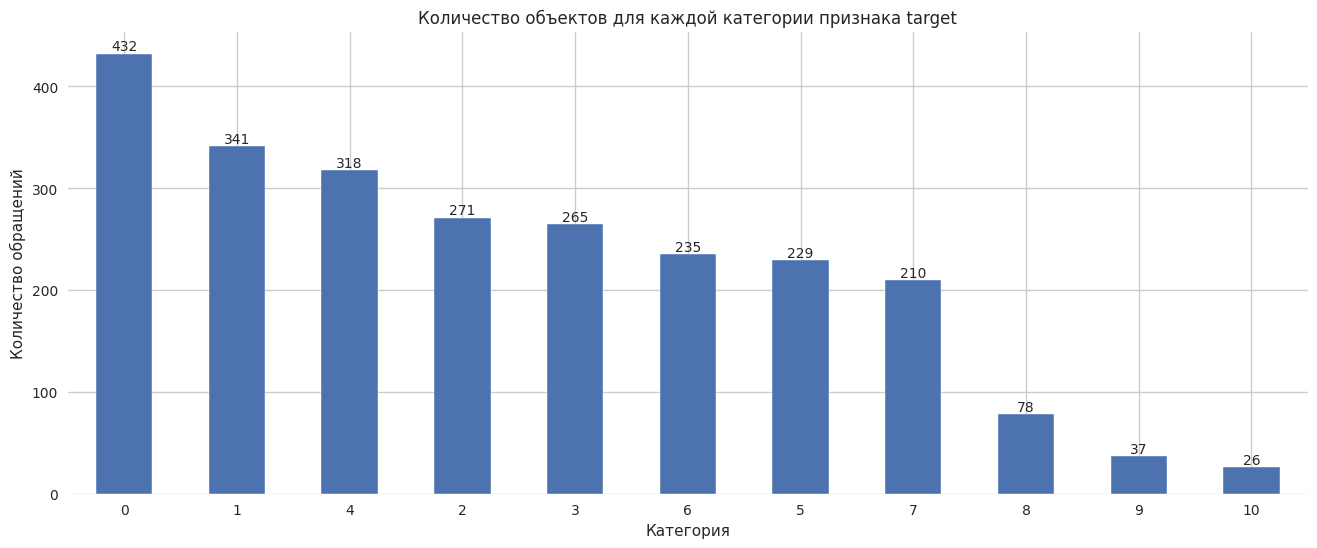

In [11]:
plot_category_counts(train_df, 'target')

Виден дисбаланс классов. 

***Наиболее часто*** встречаются запросы связанные с **проблемой с доступом в интернет**.

***Менее часто*** встречаются обращения связанные с **оборудованием и его установкой**.

### Оценим распределение длин текстов в символах

In [12]:
def plot_review_length_distribution(df, review_column):
    # Вычисляем длины текстов в указанной колонке
    review_lengths = df[review_column].apply(len)

    # Строим гистограмму распределения длин текстов
    plt.figure(figsize=(10, 6))
    sns.histplot(review_lengths, bins=40, edgecolor='black')
    plt.title('Распределение длин текстов по символам')
    plt.xlabel('Длина текста (в символах)'')
    plt.ylabel('Количество обращений')
    plt.show()

In [13]:
def plot_review_word_count_distribution(df, review_column):
    # Вычисляем количество слов в указанной колонке
    word_counts = df[review_column].apply(lambda x: len(x.split()))

    # Строим гистограмму распределения количества слов
    plt.figure(figsize=(10, 6))
    sns.histplot(word_counts, bins=40, edgecolor='black')
    plt.title('Распределение длин текстов по количеству слов')
    plt.xlabel('Количество слов')
    plt.ylabel('Количество обращений')
    plt.show()

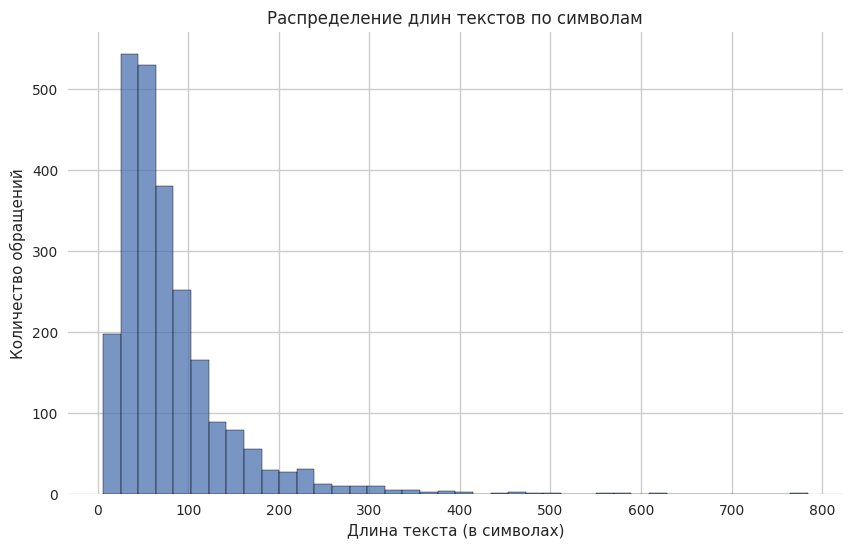

In [14]:
plot_review_length_distribution(train_df, 'text')

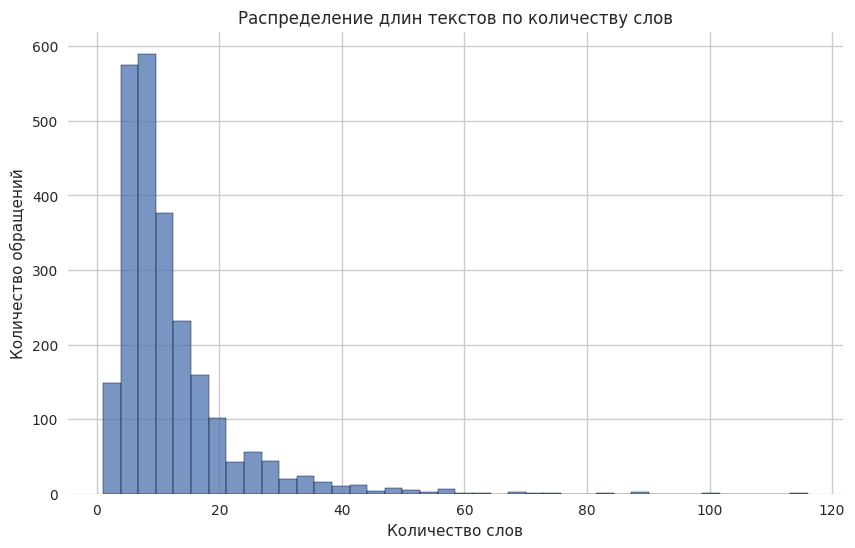

In [15]:
plot_review_word_count_distribution(train_df, 'text')

Большинство отзывов не превышают 200 символов и 30 слов. Имеются выбросы.

In [16]:
def generateNgrams(documents, size):
    ngrams_all = []

    for document in documents: 
        document = document.split()

        if len(document) < size:
            continue
        else:
            output = list(ngrams(document, size))  

        for ngram in output:
            ngrams_all.append(' '.join(ngram))

    count_ngram = Counter()

    for word in ngrams_all:  
        count_ngram[word] += 1


    df = pd.DataFrame.from_dict(count_ngram, orient='index').reset_index()
    df = df.rename(columns={'index': 'words', 0: 'count'})
    df = df.sort_values(by='count', ascending=False)  
    df = df.head(25)  
    df = df.sort_values(by='count')

    return df

In [17]:
def plotNgrams(documents, title):
    unigrams = generateNgrams(documents, 1)
    bigrams = generateNgrams(documents, 2)
    trigrams = generateNgrams(documents, 3)

    fig = plt.figure(figsize=(20, 7))
    plt.subplots_adjust(wspace=0.5)

    fig.suptitle(title, fontsize=16)

    # plot 1
    ax = fig.add_subplot(131)
    ax.barh(
        np.arange(len(unigrams['words'])), unigrams['count'], align='center', alpha=1
    )
    ax.set_title('Unigrams')
    plt.yticks(np.arange(len(unigrams['words'])), unigrams['words'])
    plt.xlabel('Count')

    # plot 2
    ax2 = fig.add_subplot(132)
    ax2.barh(
        np.arange(len(bigrams['words'])),
        bigrams['count'],
        align='center',
        alpha=1,
        color='red',
    )
    ax2.set_title('Bigrams')
    plt.yticks(np.arange(len(bigrams['words'])), bigrams['words'])
    plt.xlabel('Count')

    # plot 3
    ax3 = fig.add_subplot(133)
    ax3.barh(
        np.arange(len(trigrams['words'])),
        trigrams['count'],
        align='center',
        alpha=1,
        color='green',
    )
    ax3.set_title('Trigrams')
    plt.yticks(np.arange(len(trigrams['words'])), trigrams['words'])
    plt.xlabel('Count')

    plt.show()

In [18]:
ngams_dict = {}

for i in range(0,11):
    ngams_dict[i] = train_df[train_df['target'] == i]

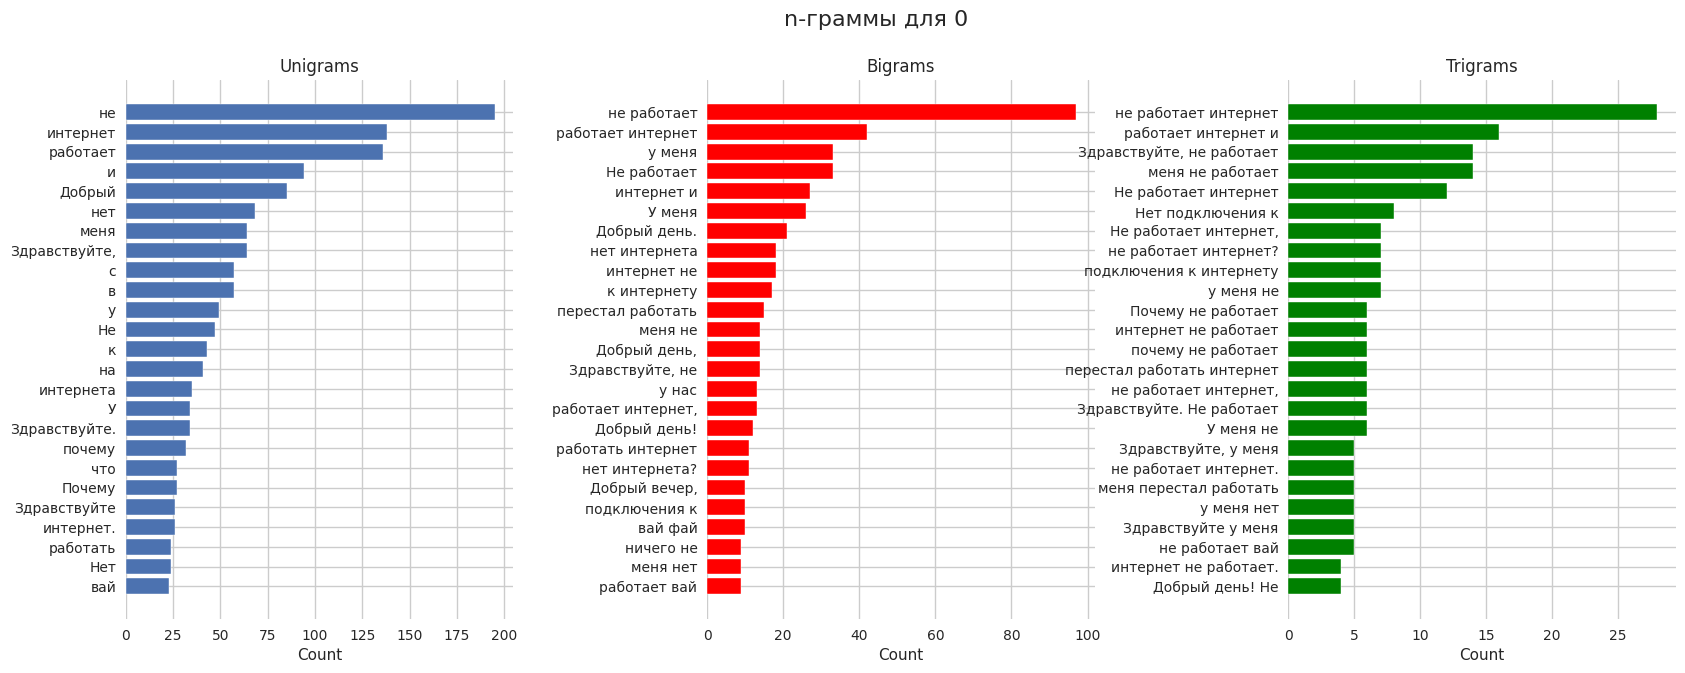

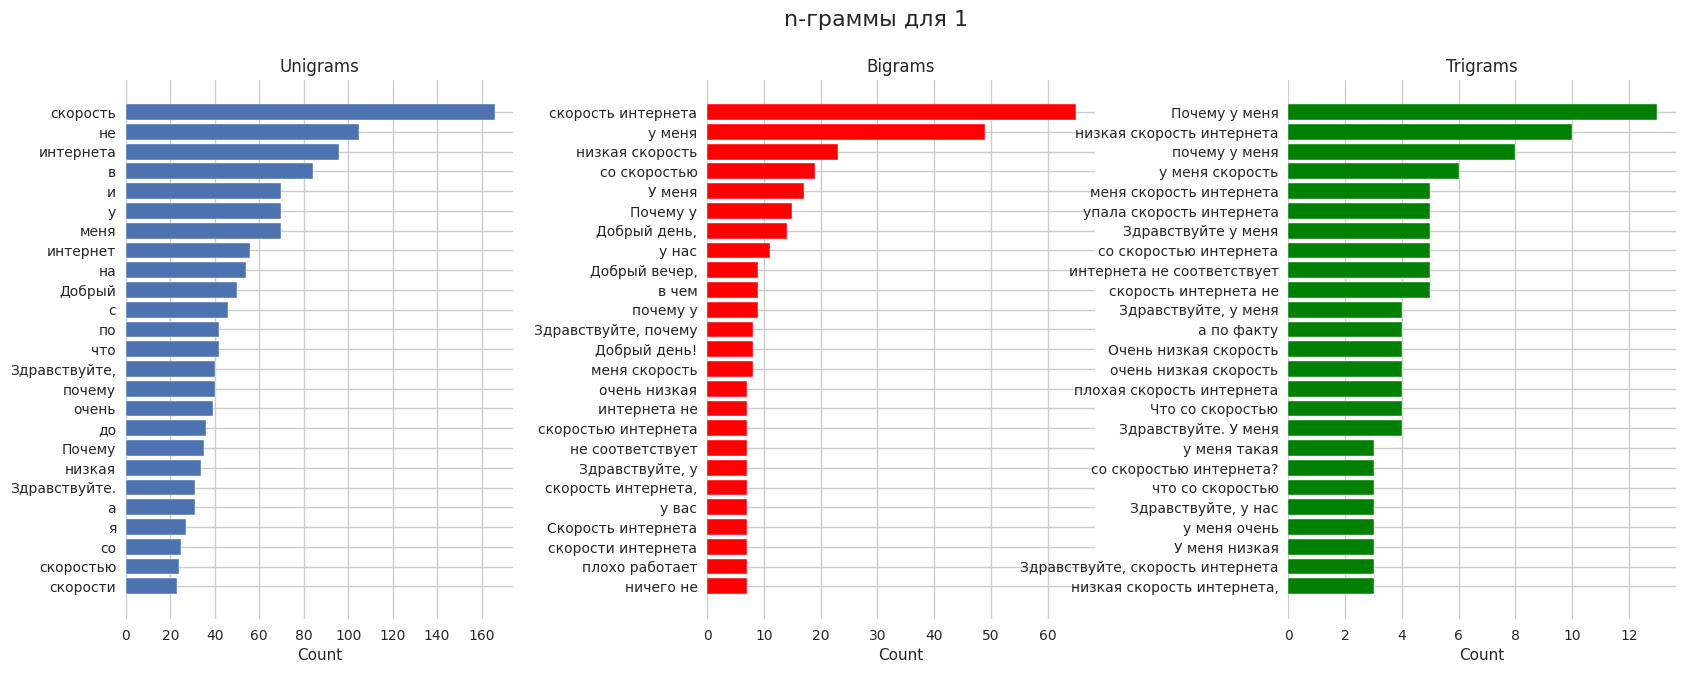

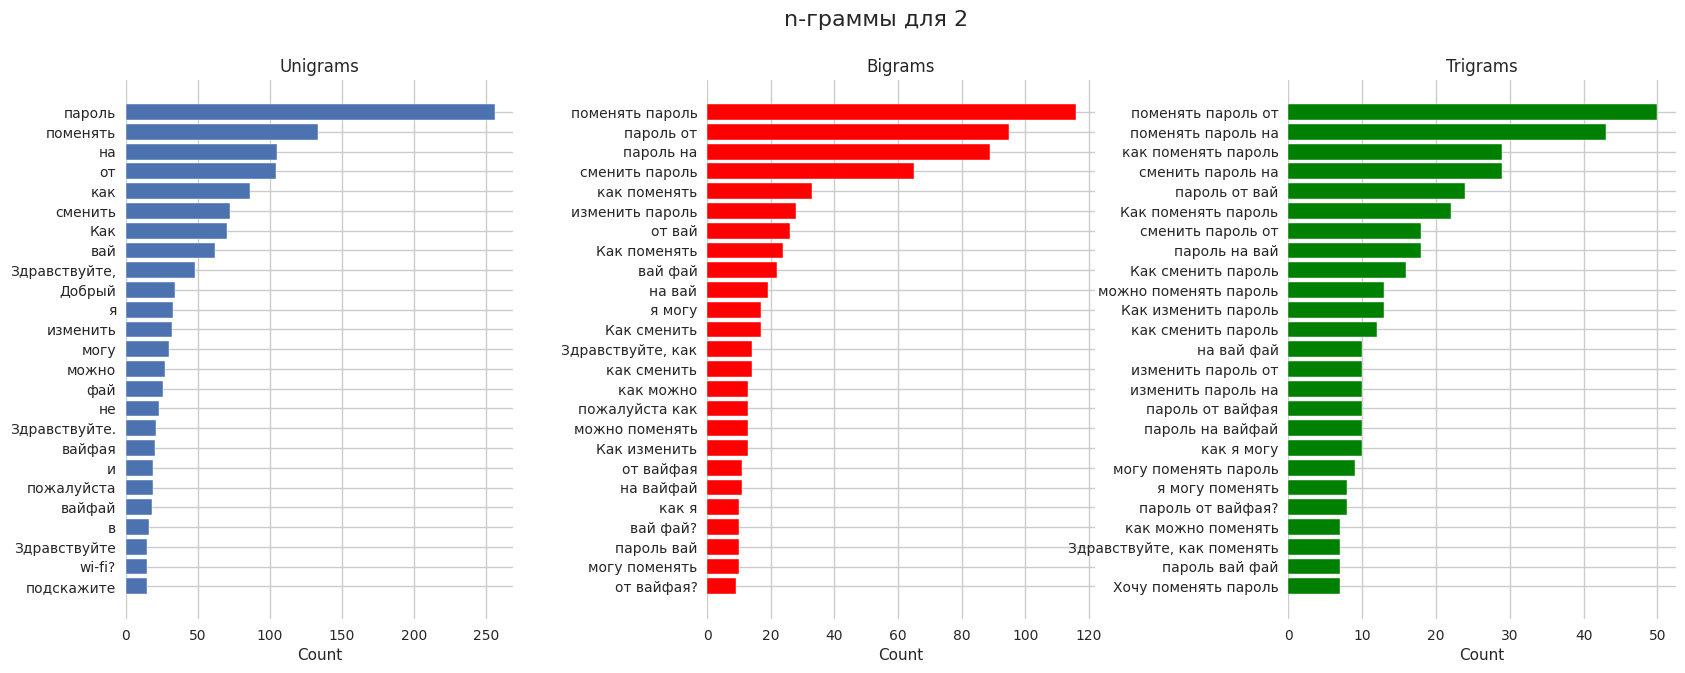

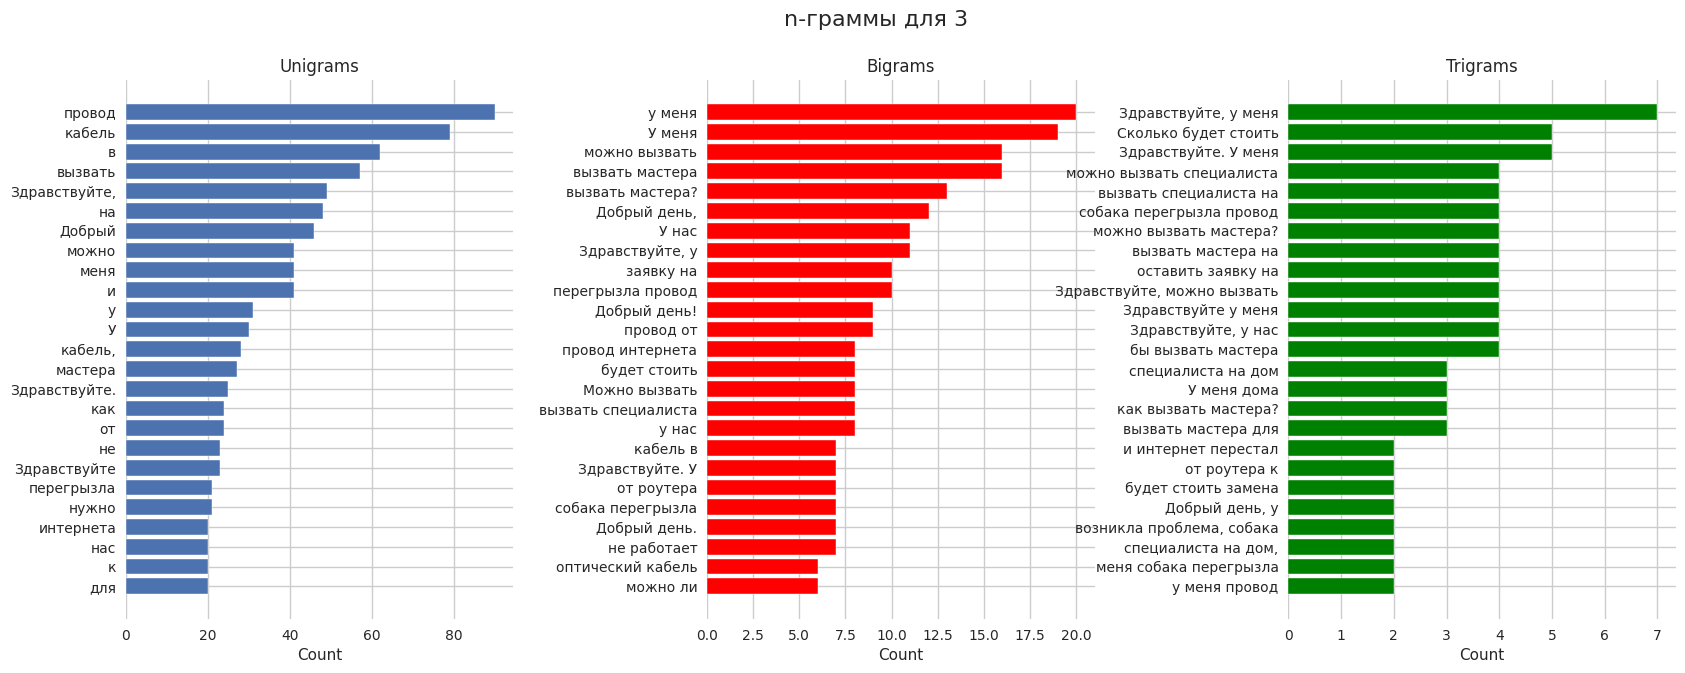

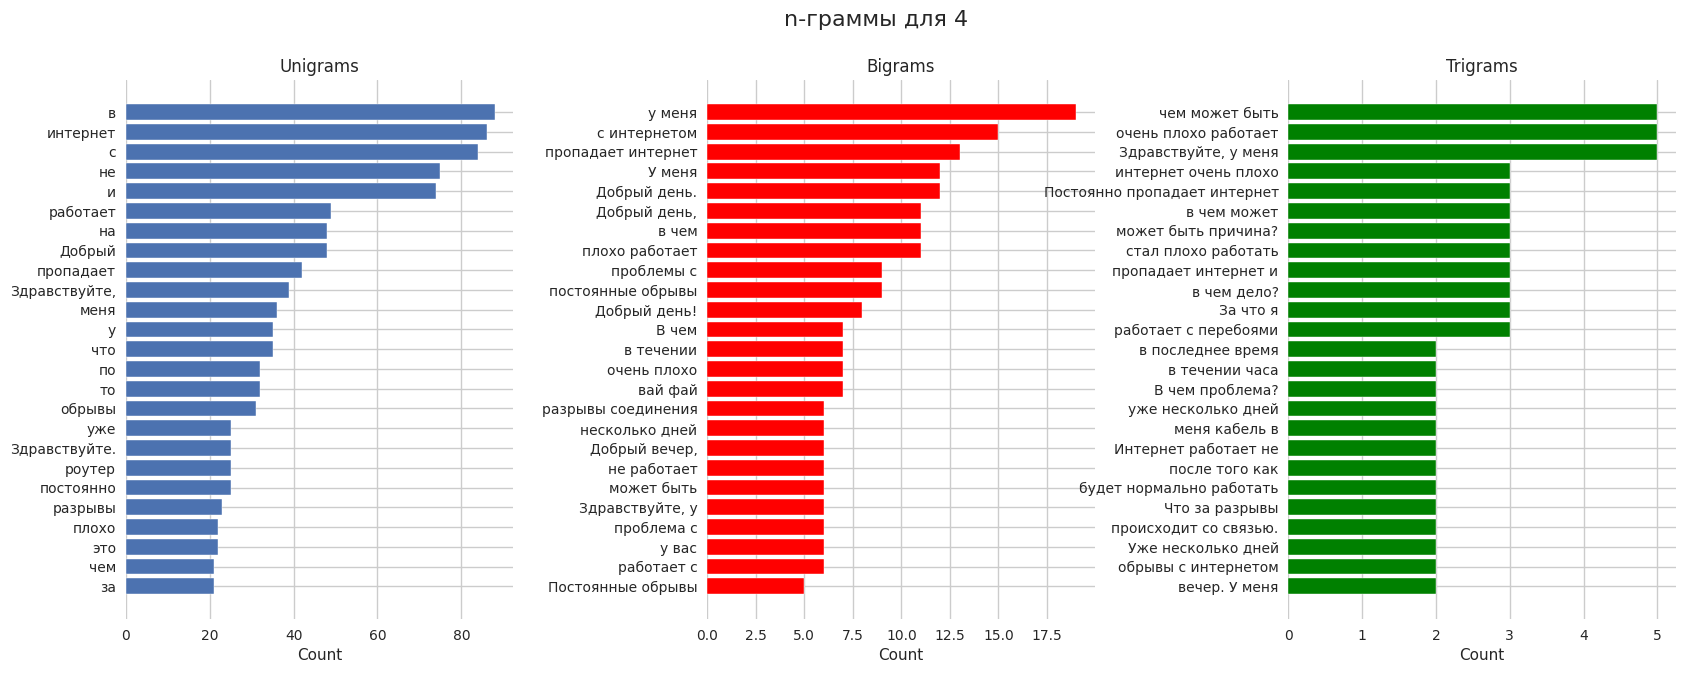

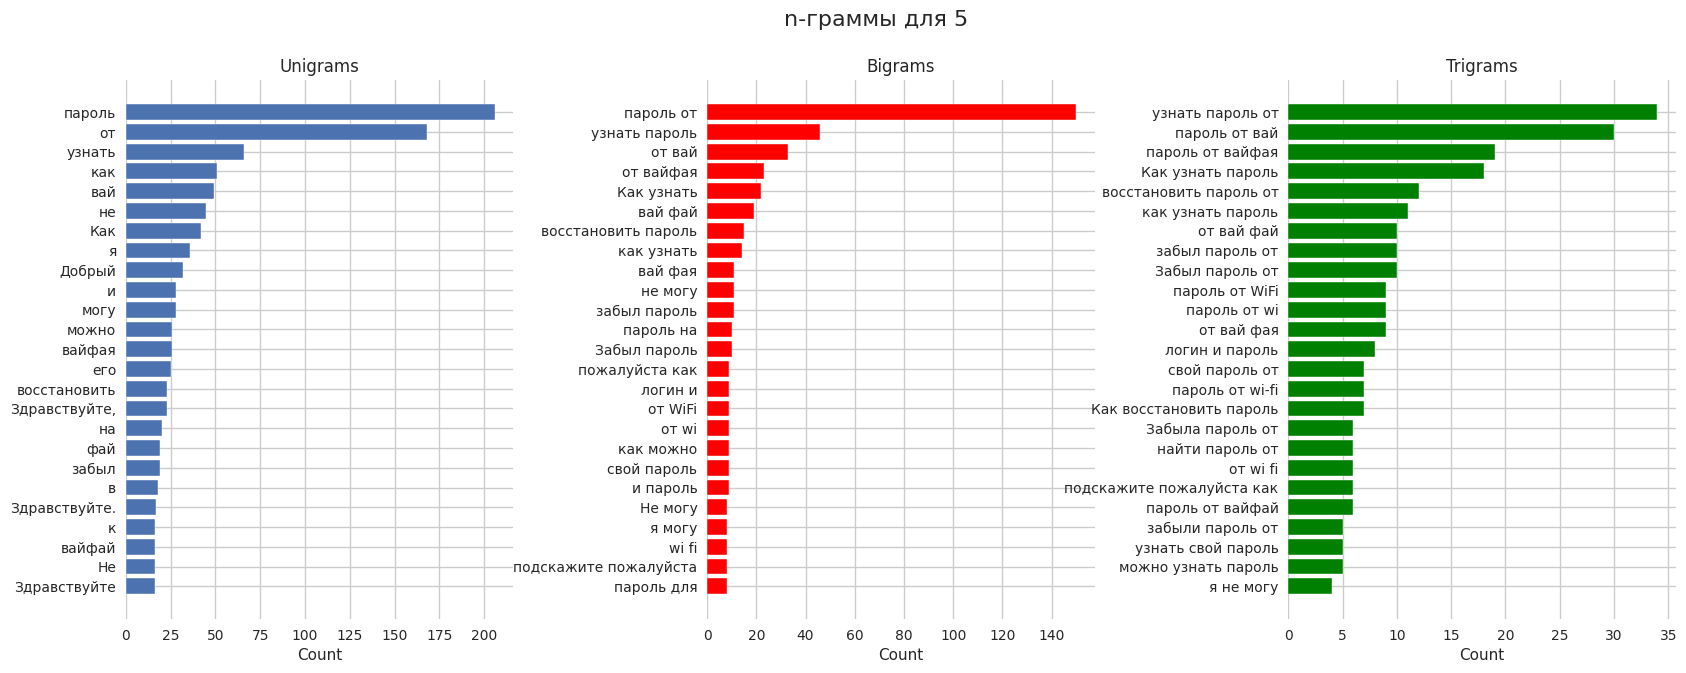

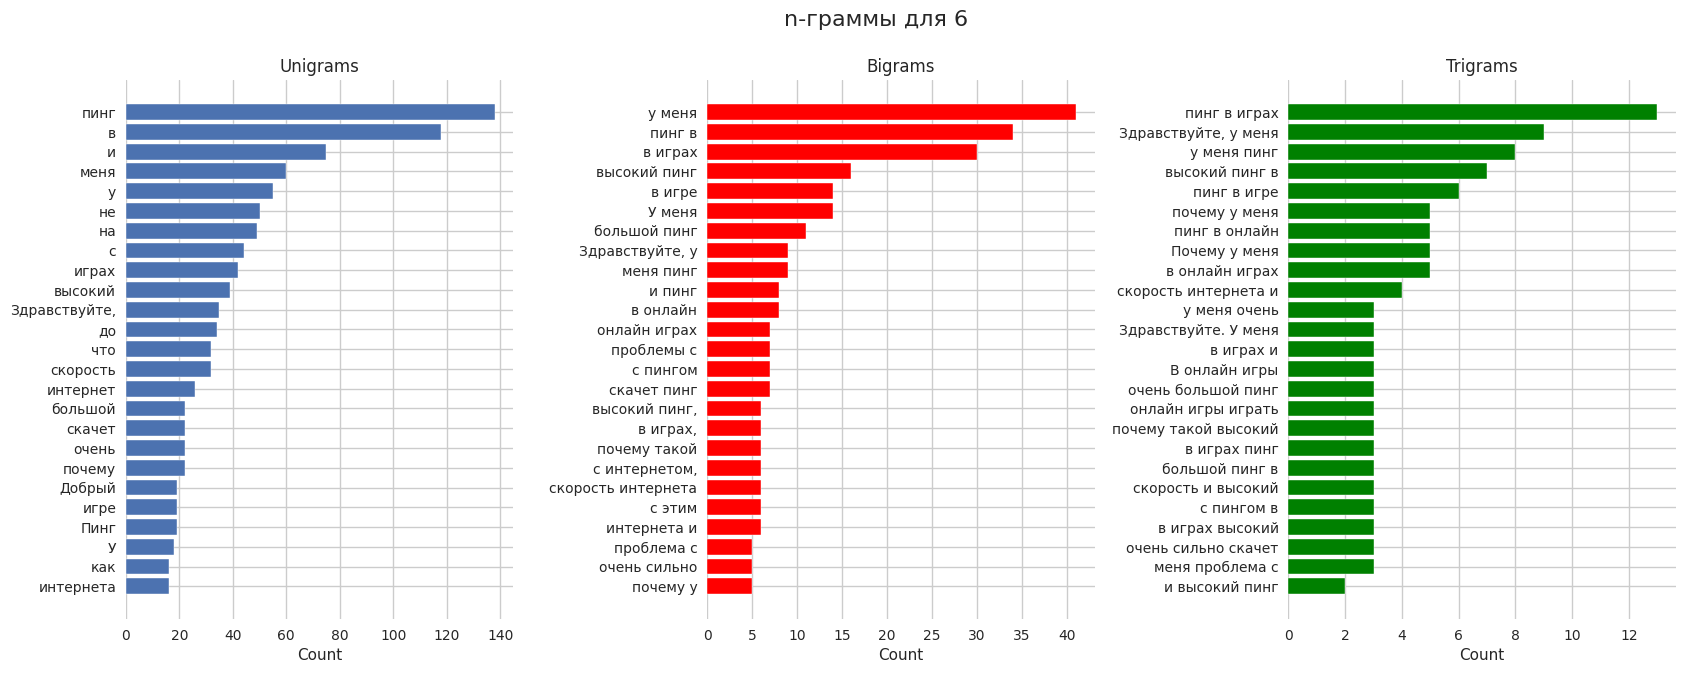

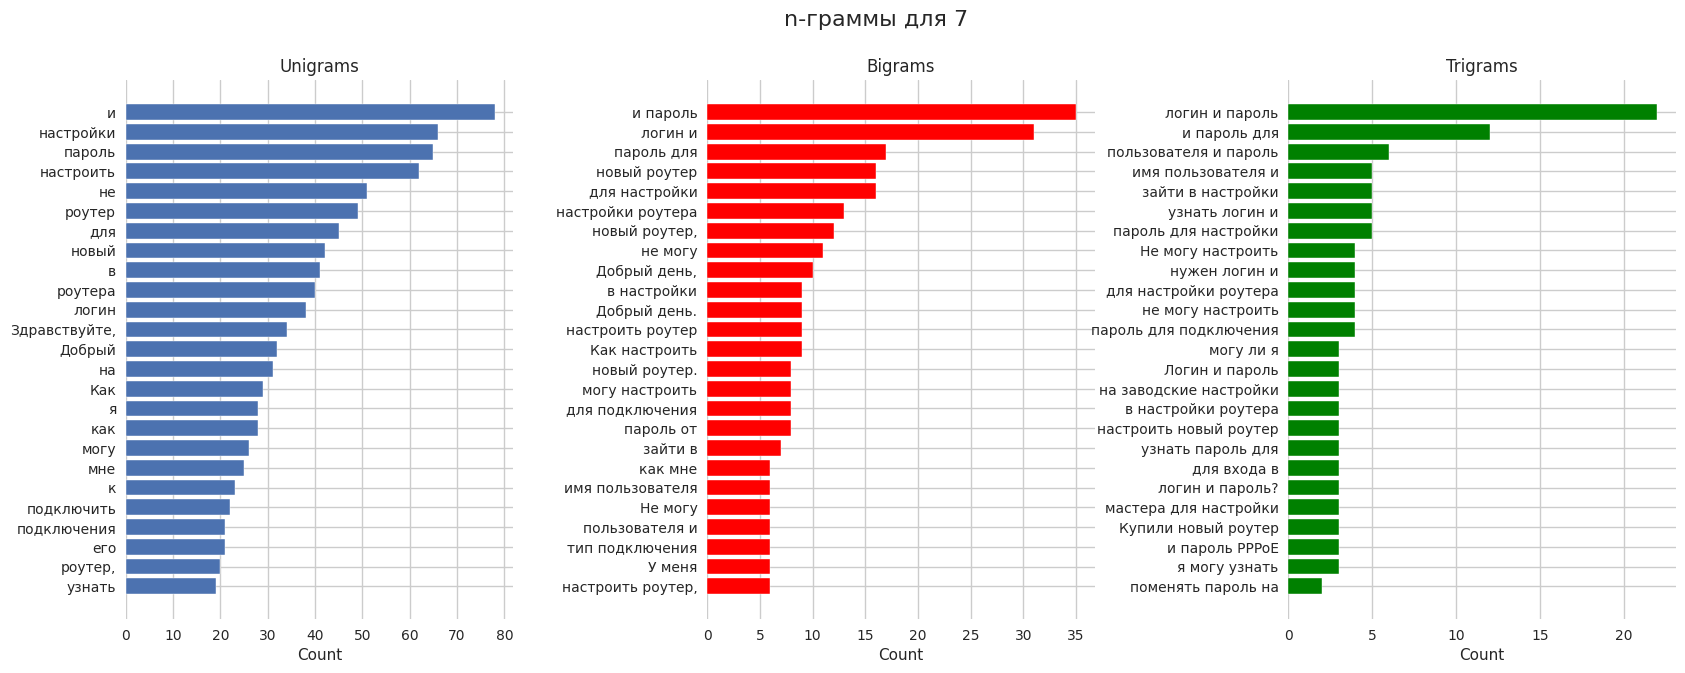

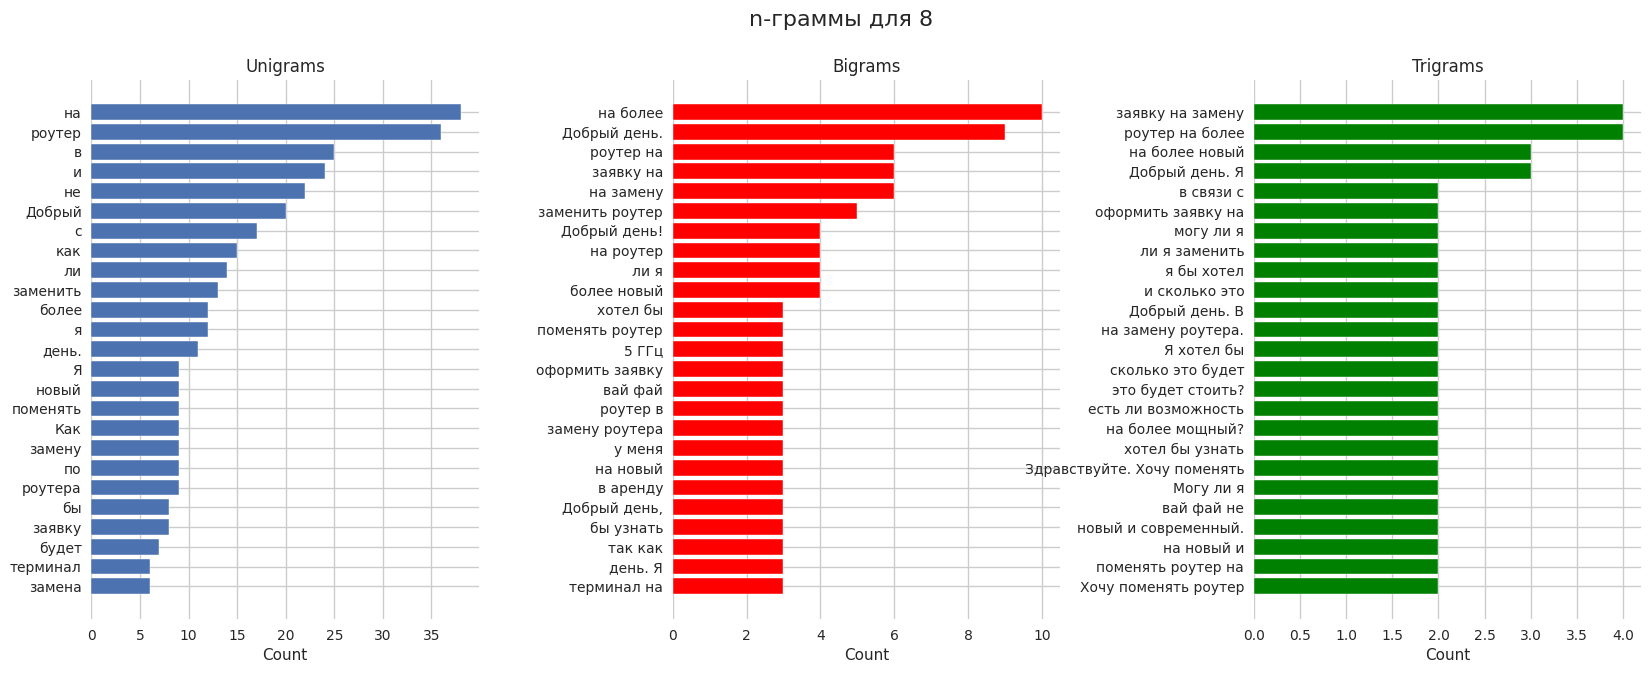

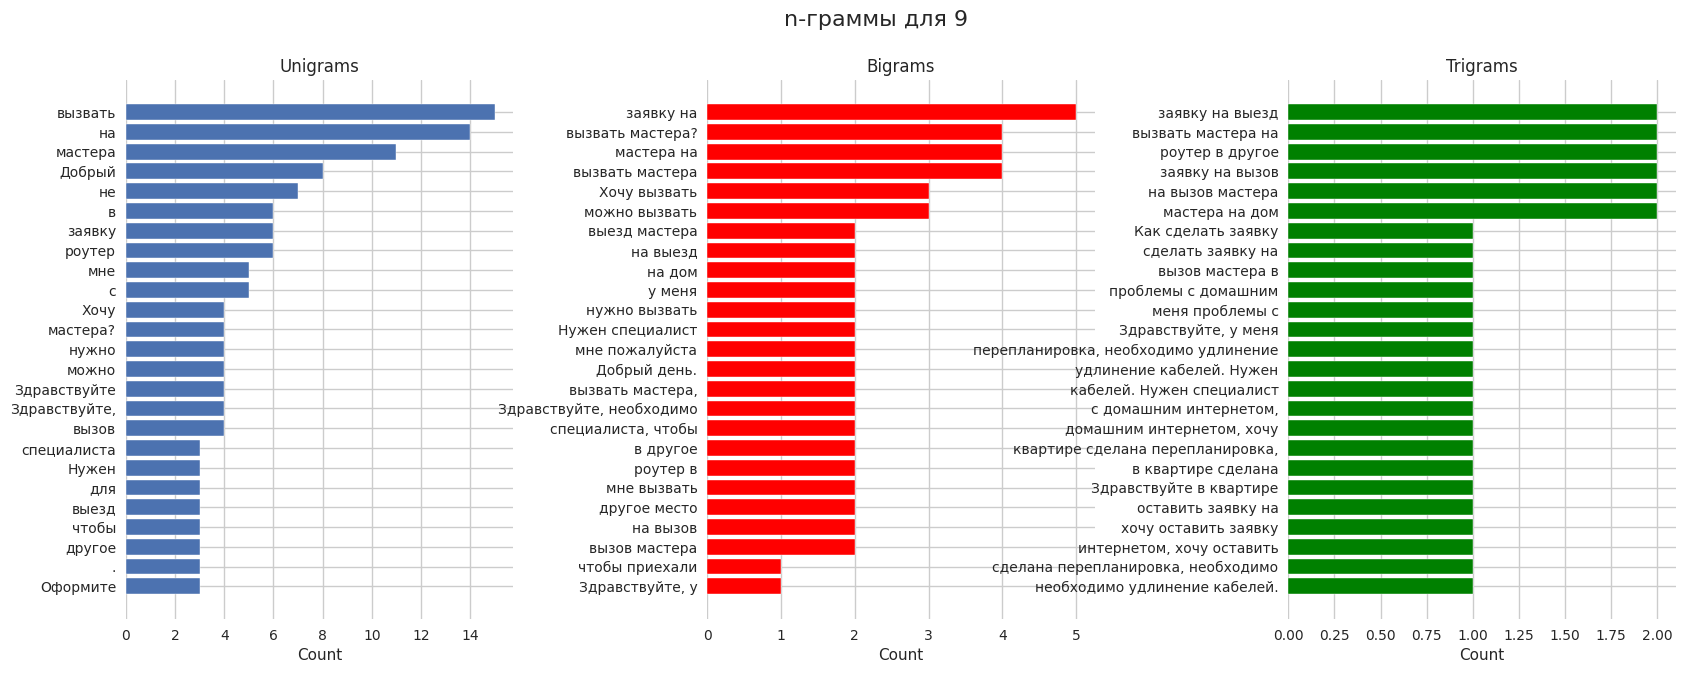

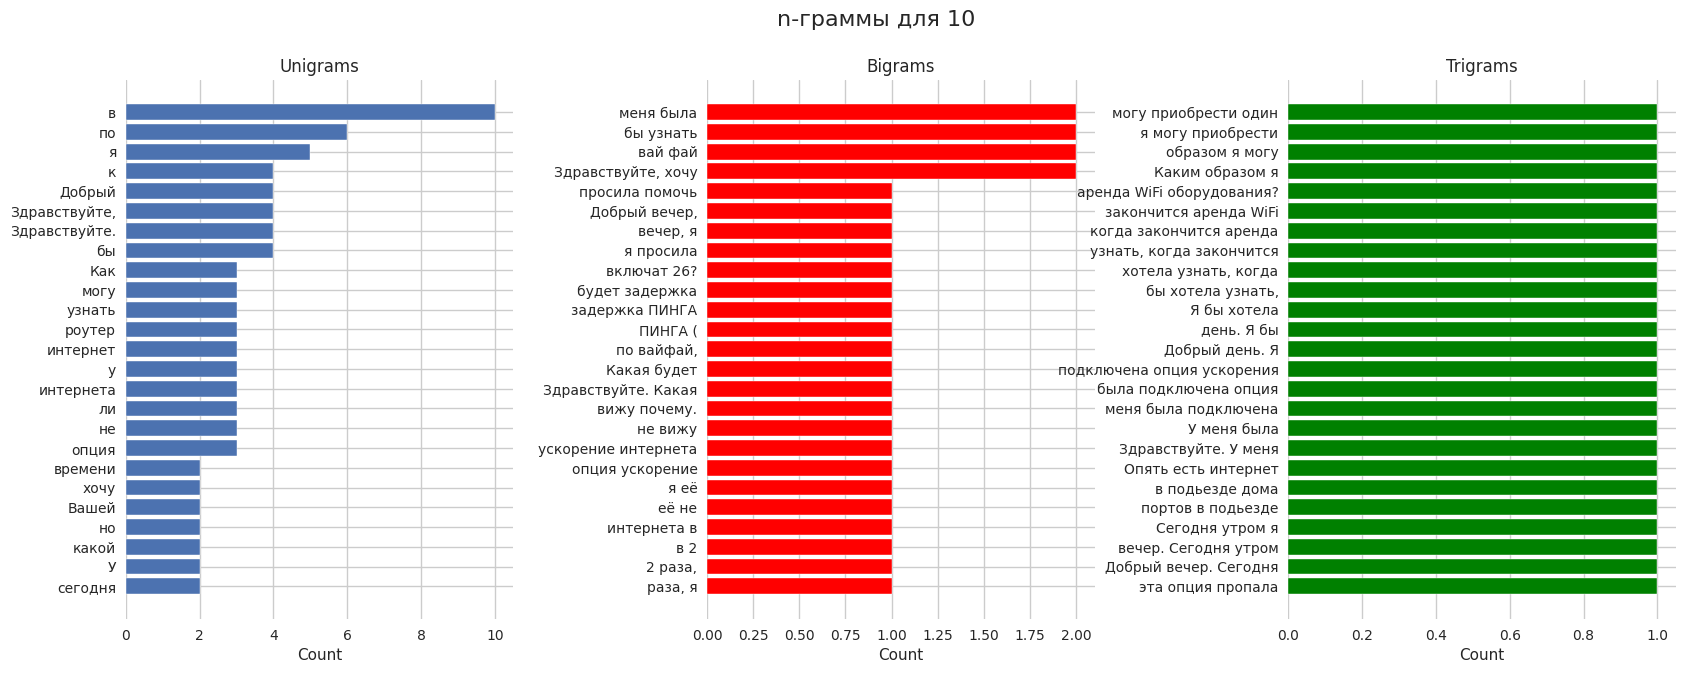

In [19]:
for target in ngams_dict:
    plotNgrams(ngams_dict[target]['text'], f'n-граммы для {target}')

### Интерпретация классов



 

| **Класс** | **Интерпретация**  |
|:--------------------- | :-------------------------- |
| **0** |Отсутствие интернета |
| **1** |Низкая скорость интернета|
| **2** |Смена пароля от wi-fi|
| **3** |Проблемы с кабелем|
| **4** |Пропадает интернет|
| **5** |Забытый пароль от wi-fi|
| **6** |Высокий пинг|
| **7** |Настройка роутера|
| **8** |Замена роутера|
| **9** |Вызов мастера|
| **10** |Общие вопросы|


### Задача модели:
#### $\bullet$ Точно классифицировать обращения для перенаправления обращений к соотвествующему менеджеру.
#### $\bullet$ Могут возникнуть сложности с классификацией 8 и 9 классов, т.к. темы запросов похожи и мало примеров. Нужно максимизировать TP для каждого из этих классов.


### Ценность для бизнеса
#### $\bullet$  Улучшения клентского опыта взаимодействия с поддержкой и увеличение лояльности, за счет уменьшения перенаправлеинй клиента к разным менеджерам.

#### $\bullet$ Сокращение среднего времени обслуживания, что может сократить затраты на колл-центр.


## Очистка текстов

In [20]:
def clean_text(text):
    # Удаляем все символы, кроме букв, цифр, пробелов и базовых знаков препинания
    cleaned_text = re.sub(r'[^А-Яа-яA-Za-z0-9 .,!?\'\"-]'', '', text)
    return cleaned_text

In [21]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

## Разделение на тренировочную и валидационную выборку

In [22]:
X = [sent.lower() for sent in train_df['text']]
y = train_df['target']

# Делим обучающую выборку на train/val и указываем stratify=y, для равномерного распределения значений таргета между выборками
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Модели

## TF-IDF + Log Reg

In [23]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train) 
X_val_tfidf = vectorizer.transform(X_val)

In [24]:
logreg = LogisticRegression(multi_class='ovr')  # Используем подход "один против всех"
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(multi_class='ovr')

In [25]:
y_pred = logreg.predict(X_val_tfidf)
print(f1_score(y_val, y_pred, average='macro'))

0.6729589019396577


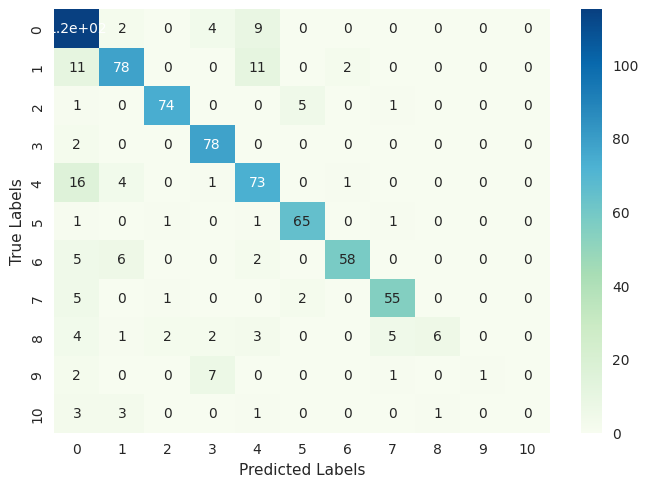

In [26]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, cmap='GnBu')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

#### $\bullet$ Модель показывает хорошее качество, но не может уловить классы обращений с 8 до 10.

#### $\bullet$  Настройка ngram_range в TfidfVectorizer не дает прироста по метрике, поэтому обучение проводится на униграммах.

### Для оценки выбрана метрика Macro F1, т.к. она не учитывает количество примеров в каждом классе, поэтому все классы равнозначны, независимо от их частоты в выборке. Это означает, что редкие классы влияют на итоговый результат так же, как и частые.

### Можно выбрать Weighted F1, но в таком случае, метрика будет зависеть от количества примеров каждого класса, но для нас важно оценивать производительность вне зависимости от того, каким количеством примеров представлен каждый класс.

## W2V + KNN


In [27]:
X_train_tokens = [sentence.split() for sentence in X_train]
X_val_tokens = [sentence.split() for sentence in X_val]

In [28]:
# Инициализвация w2v модели
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [29]:
def document_to_vector(tokens, model):
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # Если ни одно слово не представлено в модели
    return np.mean(word_vectors, axis=0)

In [30]:
X_train_vectors = np.array([document_to_vector(tokens, word2vec_model) for tokens in X_train_tokens])
X_val_vectors = np.array([document_to_vector(tokens, word2vec_model) for tokens in X_val_tokens])

In [31]:
knn = KNeighborsClassifier(n_neighbors=4)  # Используем 4 ближайших соседа
knn.fit(X_train_vectors, y_train)

KNeighborsClassifier(n_neighbors=4)

In [32]:
y_pred = knn.predict(X_val_vectors)

print(f1_score(y_val, y_pred, average='macro'))

0.23825128169351553


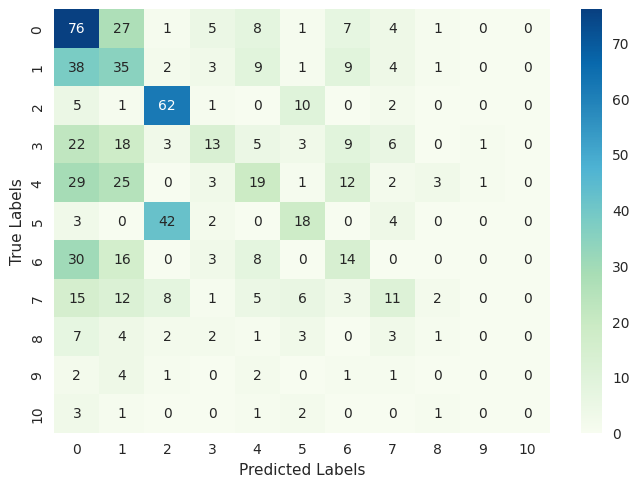

In [33]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, cmap='GnBu')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

#### $\bullet$ KNN показал себя сильно хуже, чем LogReg. Большое количество ложных предсказаний, даже в классах, которые представлены в большем количестве в выборке. 

#### $\bullet$ Подбор n_neighbors не дал результата. При числе классов больше чем 4, модель распределет предсказания между [0; 5] классами.


## Fine-tuning трансформера

#### Bert Tokenizer + Bert for sequence classification

In [34]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [35]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts  # Список текстов
        self.labels = labels.reset_index(drop=True) if isinstance(labels, pd.Series) else labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx]  # Используем правильное индексирование
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [36]:
# Создание DataLoader
train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [37]:
# Инициализация модели
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=11)

# Определение устройства (CPU или GPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [38]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def eval_model(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)

            total_loss += loss.item()
            
    return total_loss / len(dataloader)

In [39]:
counter = Counter(y_train)
class_counts = list(counter.values())  # количество примеров для каждого класса
weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float32)

# Используем веса в CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))

optimizer = AdamW(model.parameters(), lr=2e-5)

In [40]:
# Количество эпох
EPOCHS = 7

# Процесс обучения
train_losses = []
eval_losses = []

for epoch in tqdm(range(EPOCHS)):
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss = eval_model(model, val_loader, loss_fn, device)
    
    train_losses.append(train_loss)
    eval_losses.append(val_loss)

    print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

 14%|█▍        | 1/7 [00:30<03:02, 30.41s/it]

Epoch 1/7, Train Loss: 2.3449, Val Loss: 2.1455


 29%|██▊       | 2/7 [00:59<02:29, 29.86s/it]

Epoch 2/7, Train Loss: 1.6790, Val Loss: 1.2182


 43%|████▎     | 3/7 [01:29<01:58, 29.73s/it]

Epoch 3/7, Train Loss: 1.0616, Val Loss: 0.9482


 57%|█████▋    | 4/7 [01:59<01:28, 29.66s/it]

Epoch 4/7, Train Loss: 0.7288, Val Loss: 0.8412


 71%|███████▏  | 5/7 [02:28<00:59, 29.62s/it]

Epoch 5/7, Train Loss: 0.6402, Val Loss: 0.8540


 86%|████████▌ | 6/7 [02:58<00:29, 29.59s/it]

Epoch 6/7, Train Loss: 0.4708, Val Loss: 0.7709


100%|██████████| 7/7 [03:27<00:00, 29.66s/it]

Epoch 7/7, Train Loss: 0.3656, Val Loss: 0.7970


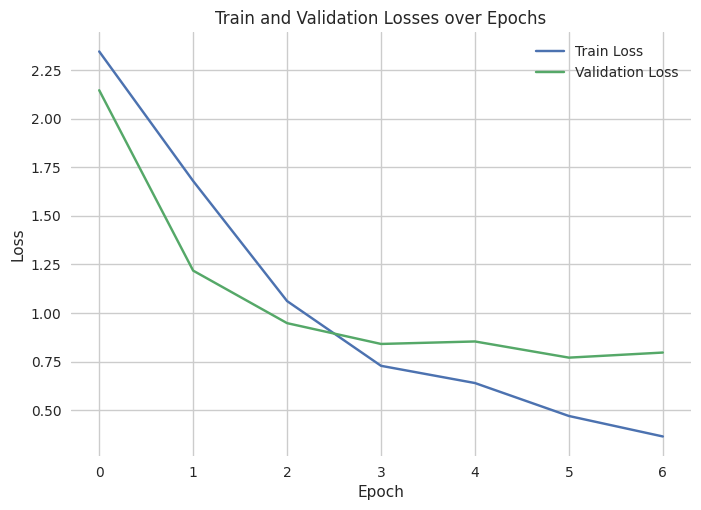

In [41]:
sns.lineplot(train_losses, markers=True, label='Train Loss')
sns.lineplot(eval_losses, markers=True, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses over Epochs')
plt.xticks(range(EPOCHS))
plt.legend()
plt.show()

In [42]:
def predict(model, tokenizer, texts, true_labels, device):
    model.eval()
    predictions = []

    for text in tqdm(texts):
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predicted_class = torch.argmax(outputs.logits, dim=-1).item()
            predictions.append(predicted_class )  # Приводим обратно к 0-10 классам
    f1 = f1_score(true_labels, predictions, average='macro')
    
    return predictions, f1

In [43]:
predicted_labels, f1 = predict(model, tokenizer, X_val, y_val, device)

print(f'f1: {f1:.4f}')

100%|██████████| 733/733 [00:07<00:00, 99.37it/s] 

f1: 0.7628


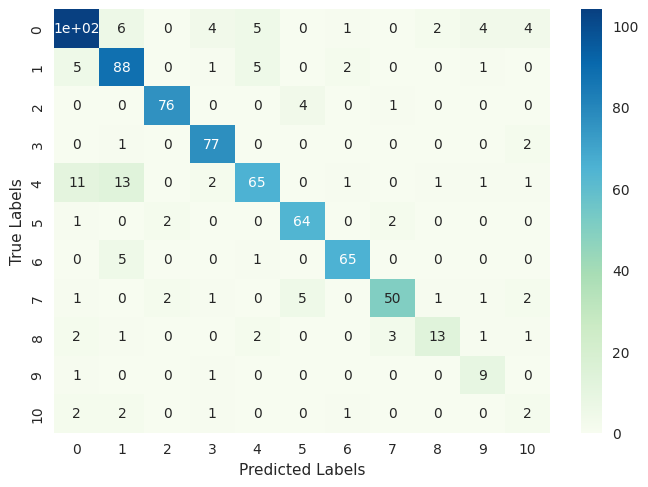

In [44]:
cm = confusion_matrix(y_val, predicted_labels)

sns.heatmap(cm, annot=True, cmap='GnBu')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### $\bullet$ Базовая модель хорошо справляется с детекцией 8 класса в сравнении с предыдущими. Но есть проблема в классификации 9 класса. Почти половине присваивает метку 8 класса (проблема была описана в задачах модели)
### $\bullet$ Добавление весов в loss позволило улучшить детекцию 9 и 10 классов.

# Итоговое предсказание 

In [45]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Создание датасета
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts  # Список текстов
        self.labels = labels.reset_index(drop=True) if isinstance(labels, pd.Series) else labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [46]:
# Инициализация модели
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=11)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [47]:
# Создание DataLoader
train_dataset = TextDataset(train_df['text'], train_df['target'], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [48]:
counter = Counter(train_df['target'])
class_counts = list(counter.values())  # количество примеров для каждого класса
weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float32)

# Используем веса в CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))

optimizer = AdamW(model.parameters(), lr=2e-5)

In [49]:
# Количество эпох
EPOCHS = 7

# Процесс обучения
for epoch in tqdm(range(EPOCHS)):
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    
    print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}')

 14%|█▍        | 1/7 [00:45<04:31, 45.25s/it]

Epoch 1/7, Train Loss: 1.7677


 29%|██▊       | 2/7 [01:30<03:46, 45.22s/it]

Epoch 2/7, Train Loss: 0.9716


 43%|████▎     | 3/7 [02:15<03:01, 45.28s/it]

Epoch 3/7, Train Loss: 0.6617


 57%|█████▋    | 4/7 [03:01<02:15, 45.31s/it]

Epoch 4/7, Train Loss: 0.5253


 71%|███████▏  | 5/7 [03:46<01:30, 45.32s/it]

Epoch 5/7, Train Loss: 0.4255


 86%|████████▌ | 6/7 [04:31<00:45, 45.34s/it]

Epoch 6/7, Train Loss: 0.3353


100%|██████████| 7/7 [05:17<00:00, 45.32s/it]

Epoch 7/7, Train Loss: 0.2654


In [50]:
def predict_test(model, tokenizer, texts, device):
    model.eval()
    predictions = []

    for text in tqdm(texts):
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predicted_class = torch.argmax(outputs.logits, dim=-1).item()
            predictions.append(predicted_class)  # Приводим обратно к 0-10 классам

    return predictions

In [51]:
test_predicted_labels = predict_test(model, tokenizer, test_df['text'], device)

100%|██████████| 250/250 [00:02<00:00, 100.60it/s]


In [52]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['y'] = test_predicted_labels

submission_df.to_csv('Polovnikov_NA.csv', index=False)

# Выводы


| **Model** | **F1-Macro** |
| :--------------------- | :-------------------------- |
| TF-IDF + LogReg | 0.67 |
| Word2Vec + KNN | 0.23 |
| Bert Tokenizer + BertForSequenceClassification | 0.76 |



### $\bullet$ Наилучшую метрику показал подход с fine-tune предобученного энкодера + классификатора.
### $\bullet$ Если важна скорость предсказания, то имеет смысл выбрать вариант TF-IDF + LogReg, но важно понимать, что качество классификации обращеиий связанных с роутером, будет низким